In [1]:
# ##  Environment Setup**
# # Install necessary packages
# !pip install transformers
# !pip install scikit-learn
# !pip install transformers[torch]
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

In [2]:
!module load Python/3.11.3

Module Python/3.11.3 and 4 dependencies unloaded.
Module Python/3.11.3 and 4 dependencies loaded.


In [8]:
##  Library Imports**
# Import libraries and modules
import torch
import numpy as np
from sklearn.metrics import f1_score
from transformers import Trainer, TrainingArguments
!export TRANSFORMERS_VERBOSITY=info
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
##  Data Loading and Preprocessing**
# Load and preprocess the dataset
import pandas as pd
import zipfile
import os
from transformers import AutoTokenizer

# Unzipping the dataset
zip_path = 'public_data_dev.zip'
output_dir = 'data/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

# Update file_path with the extracted data path
data_path = 'data/public_data_dev/track_a/train/eng.csv'

# Load data
data = pd.read_csv(data_path)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# # Tokenize the entire dataset upfront
# tokens = tokenizer(
#     data['text'].tolist(),
#     padding=True,
#     truncation=True,
#     return_tensors='pt',
#     max_length=128
# )

#print(data)
#print(tokens)

In [10]:
##  Dataset Preparation**
# Create train and validation datasets
from sklearn.model_selection import train_test_split

labels = data[['anger', 'fear', 'joy', 'sadness', 'surprise']].values

#print(labels)
#print("Labels shape:", labels.shape)

In [11]:
# Check for missing values in the labels columns
print(data[['anger', 'fear', 'joy', 'sadness', 'surprise']].isnull().sum())

anger       0
fear        0
joy         0
sadness     0
surprise    0
dtype: int64


In [12]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['text'].tolist(), labels.tolist(), test_size=0.2, random_state=62
)

class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=128,
        )
        return {
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

train_dataset = EmotionDataset(train_texts, train_labels, tokenizer)
val_dataset = EmotionDataset(val_texts, val_labels, tokenizer)
#print(len(train_dataset))

In [13]:
##  Model Initialization**
# Initialize the pre-trained model
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=5,
    problem_type = "multi_label_classification"
)
model = model.to(device)

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
##  Training Setup**
# Define training arguments
training_args = TrainingArguments(
    output_dir='/data/horse/ws/hama461f-BSLLM/final/bert_results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='/data/horse/ws/hama461f-BSLLM/final/logs',
    load_best_model_at_end=True
)
#For Colab only
#import os
#os.environ["WANDB_DISABLED"] = "true"

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [10]:
##  Model Training**
# Train the model
trainer.train()

/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.439547
2,No log,0.388950
3,No log,0.405845
4,No log,0.423073
5,No log,0.449095
6,No log,0.474480
7,No log,0.497376
8,0.209800,0.506262
9,0.209800,0.514153
10,0.209800,0.515592


/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site

TrainOutput(global_step=700, training_loss=0.15708254405430386, metrics={'train_runtime': 97.0813, 'train_samples_per_second': 228.056, 'train_steps_per_second': 7.21, 'total_flos': 1456358918538240.0, 'train_loss': 0.15708254405430386, 'epoch': 10.0})

In [11]:
trainer.model.save_pretrained("/data/horse/ws/hama461f-BSLLM/final/bert_results/best_model")

## Evaluation

# Evaluate model and compute F1 score
predictions = trainer.predict(val_dataset)
pred_labels = (torch.sigmoid(torch.tensor(predictions.predictions)) > 0.5).float()

# Convert predictions and labels to numpy
pred_labels_np = pred_labels.cpu().numpy()
val_labels_np = torch.tensor(val_labels).cpu().numpy()

# Calculate F1 Score
f1 = f1_score(val_labels_np, pred_labels_np, average='micro')
print(f"F1 Score: {f1}")

/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


F1 Score: 0.7033492822966507


In [12]:
## **Improvement attempts**

In [15]:
# Updated Training Arguments with Optimizations
#********************************
#For Colab only
#import os
#os.environ["WANDB_DISABLED"] = "true"
#*********************************
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.metrics import f1_score


model2 = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=5,
    problem_type = "multi_label_classification"
)
model2 = model2.to(device)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    pred_labels = (torch.sigmoid(torch.tensor(predictions)) > 0.5).numpy()
    f1 = f1_score(labels, pred_labels, average='micro')
    return {"f1": f1}



optimized_training_args = TrainingArguments(
    output_dir='/data/horse/ws/hama461f-BSLLM/final/optimized_bert_results',
    num_train_epochs=25,  
    per_device_train_batch_size=32, 
    evaluation_strategy="epoch",  
    save_strategy="epoch", 
    save_total_limit = 2,
    warmup_steps=500,  
    learning_rate=2e-5, 
    weight_decay=0.1,  
    fp16=True,  
    logging_dir='/data/horse/ws/hama461f-BSLLM/final/optimized_bert_logs',
    load_best_model_at_end=True,
    metric_for_best_model="f1",  
    greater_is_better=True
)

# Reinitialize Trainer with Optimized Parameters
optimized_trainer = Trainer(
    model=model2,
    args=optimized_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train with Optimized Settings
optimized_trainer.train()

# Evaluate the model with optimized settings
optimized_predictions = optimized_trainer.predict(val_dataset)
optimized_pred_labels = (torch.sigmoid(torch.tensor(optimized_predictions.predictions)) > 0.5).float()

# Convert predictions and labels to numpy
optimized_pred_labels_np = optimized_pred_labels.cpu().numpy()
optimized_val_labels_np = torch.tensor(val_labels).cpu().numpy()

optimized_trainer.model.save_pretrained("/data/horse/ws/hama461f-BSLLM/final/optimized_bert_results/best_model")

# Calculate F1 Score for Optimized Model
optimized_f1 = f1_score(optimized_val_labels_np, optimized_pred_labels_np, average='micro')
print(f"Optimized F1 Score: {optimized_f1}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/h5/hama461f/my_env/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,No log,0.660367,0.357143
2,No log,0.571354,0.459706
3,No log,0.501546,0.478537
4,No log,0.450730,0.612000
5,No log,0.414214,0.711394
6,No log,0.389397,0.706983
7,No log,0.385752,0.724515
8,0.465500,0.412716,0.719615
9,0.465500,0.405310,0.722026
10,0.465500,0.421132,0.722188


Optimized F1 Score: 0.7245145631067961


/home/h5/hama461f/my_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h5/hama461f/my_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h5/hama461f/my_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


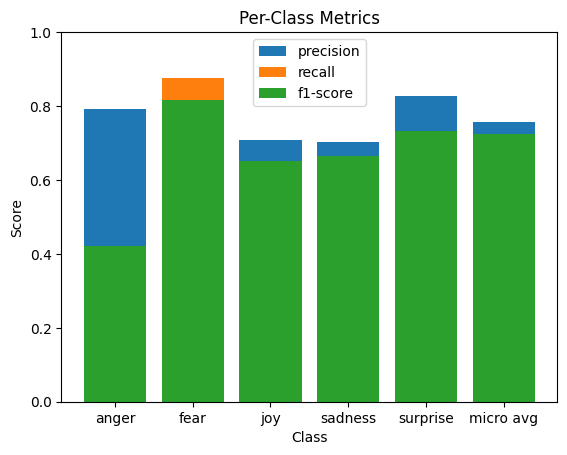

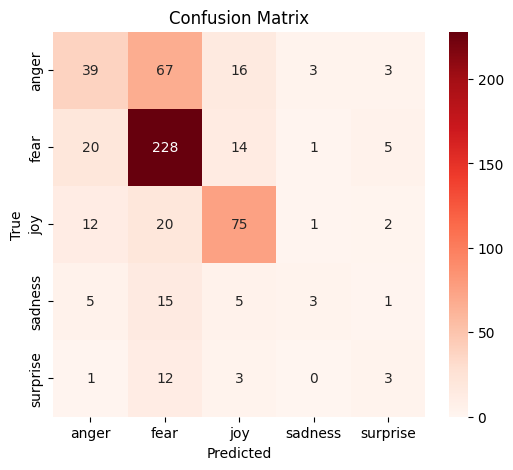

In [19]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
# Per-Class Metrics Visualization
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

report_dict = classification_report(optimized_val_labels_np, optimized_pred_labels_np, target_names=["anger", "fear", "joy", "sadness", "surprise"], output_dict=True)

# Plot precision, recall, and F1 for each class
classes = list(report_dict.keys())[:-3]  # Ignore overall metrics
metrics = ['precision', 'recall', 'f1-score']

for metric in metrics:
    values = [report_dict[cls][metric] for cls in classes]
    plt.bar(classes, values, label=metric)

plt.title("Per-Class Metrics")
plt.xlabel("Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.show()




from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(optimized_val_labels_np.argmax(axis=1), optimized_pred_labels_np.argmax(axis=1))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["anger", "fear", "joy", "sadness", "surprise"], yticklabels=["anger", "fear", "joy", "sadness", "surprise"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [16]:
# Custom BERT Model with Expanded Layer
from transformers import BertModel
import torch.nn as nn

# Custom BERT Architecture with Frozen Base
class CustomBERTModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super(CustomBERTModel, self).__init__()
        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained(model_name)
        # Freeze BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False

        # Unfreeze last encoder layers for better finetuning
        for param in self.bert.encoder.layer[-6:].parameters(): 
            param.requires_grad = True
        
        # Dropout & LayerNorm
        self.dropout = nn.Dropout(p=0.5)
        self.layernorm = nn.LayerNorm(512)
        
        # Classificafication layer
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 512)  # Intermediate layer
        self.fc2 = nn.Linear(512, num_labels) 
        
        
        # Activation function
        self.gelu = nn.GELU()
    
    def forward(self, input_ids, attention_mask, labels=None):
        # Pass inputs through BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        
        # Get the [CLS] token representation
        cls_output = outputs.pooler_output
        
        # Pass through additional layers
        x = self.dropout(cls_output)
        x = self.fc1(x)
        x = self.layernorm(x)
        x = self.gelu(x)
        x = self.dropout(x)
        logits = self.fc2(x)
        
        if labels is not None:
            # Apply BCEWithLogitsLoss for multi-label classification
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        
        return {"logits": logits}

# Initialize custom model
custom_model_name = 'bert-base-uncased'
custom_num_labels = 5 # 5 emotions
custom_model = CustomBERTModel(custom_model_name, custom_num_labels)

# Move custom model to device
custom_model = custom_model.to(device)

# Define new TrainingArguments
custom_training_args = TrainingArguments(
    output_dir='/data/horse/ws/hama461f-BSLLM/final/custom_bert_results',
    num_train_epochs=25,  
    per_device_train_batch_size=32, 
    evaluation_strategy="epoch", 
    save_strategy="epoch", 
    save_steps=1000,  
    learning_rate=2e-5, 
    weight_decay=0.2,  
    fp16=True,  
    logging_dir='/data/horse/ws/hama461f-BSLLM/final/custom_logs',
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True
)

# Define Trainer with Custom Model
custom_trainer = Trainer(
    model=custom_model,
    args=custom_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train Custom Model
custom_trainer.train()

from sklearn.metrics import roc_curve

def find_best_thresholds_roc(y_true, y_pred_probs):
    thresholds = []
    for i in range(y_true.shape[1]):
        fpr, tpr, th = roc_curve(y_true[:, i], y_pred_probs[:, i])
        best_th = th[(tpr - fpr).argmax()]
        thresholds.append(best_th)
    return thresholds

# Generate predictions on the validation set
custom_predictions = custom_trainer.predict(val_dataset)

custom_val_labels_np = torch.tensor(val_labels).cpu().numpy()

# Get optimal thresholds using ROC-AUC
best_thresholds = find_best_thresholds_roc(custom_val_labels_np, torch.sigmoid(torch.tensor(custom_predictions.predictions)).cpu().numpy())

# Apply optimized thresholds
custom_pred_labels_np = (torch.sigmoid(torch.tensor(custom_predictions.predictions)).cpu().numpy() > best_thresholds).astype(int)

save_path = "/data/horse/ws/hama461f-BSLLM/final/custom_bert_results/best_model.pth"
torch.save(custom_trainer.model.state_dict(), save_path)
print(f"Custom model saved at: {save_path}")

# Calculate F1 Score for Custom Model
custom_f1 = f1_score(custom_val_labels_np, custom_pred_labels_np, average='micro')
print(f"Custom Model F1 Score: {custom_f1}")

/home/h5/hama461f/my_env/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,No log,0.568029,0.449788
2,No log,0.514221,0.493324
3,No log,0.459613,0.604140
4,No log,0.430982,0.646722
5,No log,0.414442,0.695652
6,No log,0.413719,0.690361
7,No log,0.411646,0.698638
8,No log,0.420242,0.702671
9,No log,0.418983,0.704626
10,No log,0.412120,0.706098


/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site

Custom model saved at: /data/horse/ws/hama461f-BSLLM/final/custom_bert_results/best_model.pth
Custom Model F1 Score: 0.6960832920178482


In [17]:
## ** Ensemble Models**

# Load other pre-trained models for ensembling
from transformers import AutoModelForSequenceClassification

# Initialize additional models (e.g., RoBERTa and DeBERTa)
bert_model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=5,
    problem_type = "multi_label_classification"
)

roberta_model = AutoModelForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=5,
    problem_type = "multi_label_classification"
)
roberta_model = roberta_model.to(device)

# DeBERTa model
deberta_model = AutoModelForSequenceClassification.from_pretrained(
    'microsoft/deberta-v3-base',
    num_labels=5,
    problem_type = "multi_label_classification"
)
deberta_model = deberta_model.to(device)

# Function to make predictions with a given model
def get_predictions(model, dataset):
    trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir='/data/horse/ws/hama461f-BSLLM/final/ensemble_temp',
            per_device_eval_batch_size=16
        ),
        eval_dataset=dataset
    )
    predictions = trainer.predict(dataset)
    pred_labels = torch.sigmoid(torch.tensor(predictions.predictions))
    return pred_labels

# Get predictions from each model
bert_predictions = get_predictions(bert_model, val_dataset)
roberta_predictions = get_predictions(roberta_model, val_dataset)
deberta_predictions = get_predictions(deberta_model, val_dataset)

# Average the predictions (probabilities)
ensemble_predictions = (bert_predictions + roberta_predictions + deberta_predictions) / 3

# Convert probabilities to binary labels using threshold of 0.5
ensemble_pred_labels = (ensemble_predictions > 0.5).float()

# Convert predictions and true labels to numpy for F1 score calculation
ensemble_pred_labels_np = ensemble_pred_labels.cpu().numpy()
val_labels_np = torch.tensor(val_labels).cpu().numpy()

# Calculate F1 Score for the ensemble model
ensemble_f1 = f1_score(val_labels_np, ensemble_pred_labels_np, average='micro')
print(f"Ensemble Model F1 Score: {ensemble_f1}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferen

/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Ensemble Model F1 Score: 0.398046398046398


In [18]:
## **Ensemble Models with Fine-Tuning**

# Define function to fine-tune and save models
def fine_tune_model(model_name, train_dataset, val_dataset, output_dir, logging_dir):
    from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

    # Load pre-trained model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
    model = model.to(device)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=16,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        warmup_steps=500,
        learning_rate=2e-5,
        weight_decay=0.01,
        fp16=True,
        logging_dir=logging_dir,
        num_train_epochs=10,  
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True
    )

    # Define trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    # Fine-tune the model
    trainer.train()

    # Save the fine-tuned model
    model.save_pretrained(output_dir)

    return model

# Fine-tune BERT, RoBERTa, and DeBERTa models
print("FT-Bert")

ftbert_model = fine_tune_model(
    "bert-base-uncased", train_dataset, val_dataset, "/data/horse/ws/hama461f-BSLLM/final/fine_tuned_bert", "/data/horse/ws/hama461f-BSLLM/final/logs_bert"
)

print("FT-Roberta")
ftroberta_model = fine_tune_model(
    "roberta-base", train_dataset, val_dataset, "/data/horse/ws/hama461f-BSLLM/final/fine_tuned_roberta", "/data/horse/ws/hama461f-BSLLM/final/logs_roberta"
)

print("FT-Deberta")
ftdeberta_model = fine_tune_model(
    "microsoft/deberta-v3-base", train_dataset, val_dataset, "/data/horse/ws/hama461f-BSLLM/final/fine_tuned_deberta", "/data/horse/ws/hama461f-BSLLM/final/logs_deberta"
)

# Get predictions from each fine-tuned model
def get_predictions(model, dataset):
    trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir="/data/horse/ws/hama461f-BSLLM/final/temp_results",
            per_device_eval_batch_size=16
        ),
        eval_dataset=dataset
    )
    predictions = trainer.predict(dataset)
    pred_labels = torch.sigmoid(torch.tensor(predictions.predictions))
    return pred_labels

ftbert_predictions = get_predictions(ftbert_model, val_dataset)
ftroberta_predictions = get_predictions(ftroberta_model, val_dataset)
ftdeberta_predictions = get_predictions(ftdeberta_model, val_dataset)

# Define weights based on validation F1 scores of individual models
ftbert_weight = 0.5  
ftroberta_weight = 0.2
ftdeberta_weight = 0.3

# Compute weighted ensemble predictions
ensemble_predictions = (
    ftbert_weight * ftbert_predictions +
    ftroberta_weight * ftroberta_predictions +
    ftdeberta_weight * ftdeberta_predictions
)

# Convert probabilities to binary labels using threshold of 0.5
ensemble_pred_labels = (ensemble_predictions > 0.4).float()

# Convert predictions and true labels to numpy for F1 score calculation
ensemble_pred_labels_np = ensemble_pred_labels.cpu().numpy()
val_labels_np = torch.tensor(val_labels).cpu().numpy()

# Calculate F1 Score for the fine-tuned ensemble model
ensemble_f1 = f1_score(val_labels_np, ensemble_pred_labels_np, average='micro')
print(f"Fine-Tuned Ensemble Model F1 Score: {ensemble_f1}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FT-Bert


/home/h5/hama461f/my_env/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,No log,0.602014,0.013746
2,No log,0.565704,0.452162
3,No log,0.533346,0.470053
4,No log,0.464859,0.645768
5,No log,0.402234,0.694789
6,No log,0.391521,0.709336
7,No log,0.384215,0.723177
8,0.466500,0.393019,0.720958
9,0.466500,0.388365,0.721951
10,0.466500,0.393593,0.723430


/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site

FT-Roberta


/home/h5/hama461f/my_env/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,No log,0.621249,0.451841
2,No log,0.568165,0.451841
3,No log,0.562440,0.443329
4,No log,0.560634,0.482851
5,No log,0.562160,0.499346
6,No log,0.556470,0.477226
7,No log,0.554520,0.459270
8,0.570800,0.565238,0.513174
9,0.570800,0.577691,0.465367
10,0.570800,0.587331,0.483703


/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site

FT-Deberta


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/h5/hama461f/my_env/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,No log,2.337459,0.499278
2,No log,2.334683,0.522430
3,No log,2.322060,0.522917
4,No log,2.322587,0.523772
5,No log,2.316585,0.535313
6,No log,2.301608,0.533228
7,No log,2.322688,0.523065
8,2.373400,2.324895,0.520052
9,2.373400,2.302893,0.525680
10,2.373400,2.317138,0.522414


/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/h5/hama461f/my_env/lib/python3.11/site

/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/home/h5/hama461f/my_env/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Fine-Tuned Ensemble Model F1 Score: 0.7284695556774547


/home/h5/hama461f/my_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h5/hama461f/my_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/h5/hama461f/my_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


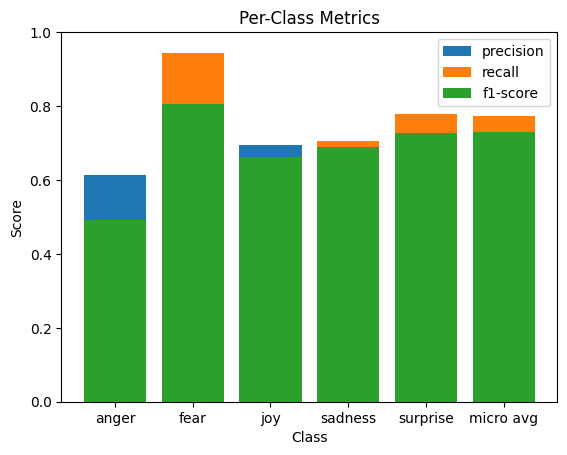


Missing Values:
 id          0
text        0
anger       0
fear        0
joy         0
sadness     0
surprise    0
dtype: int64

Number of Duplicate Texts: 4

Label Distribution:
 anger        333
fear        1611
joy          674
sadness      878
surprise     839
dtype: int64


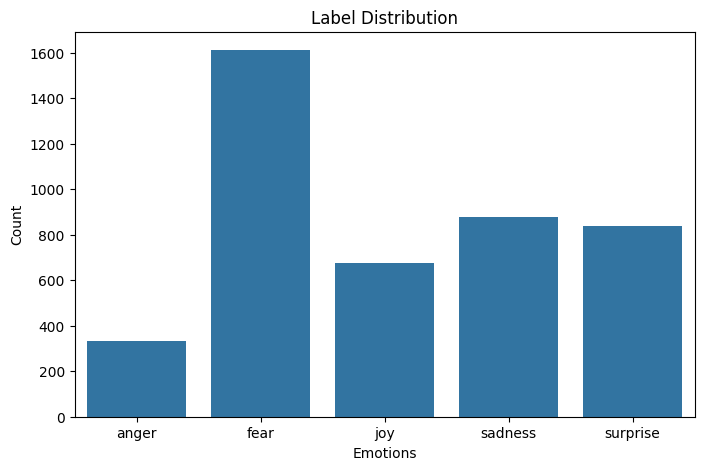

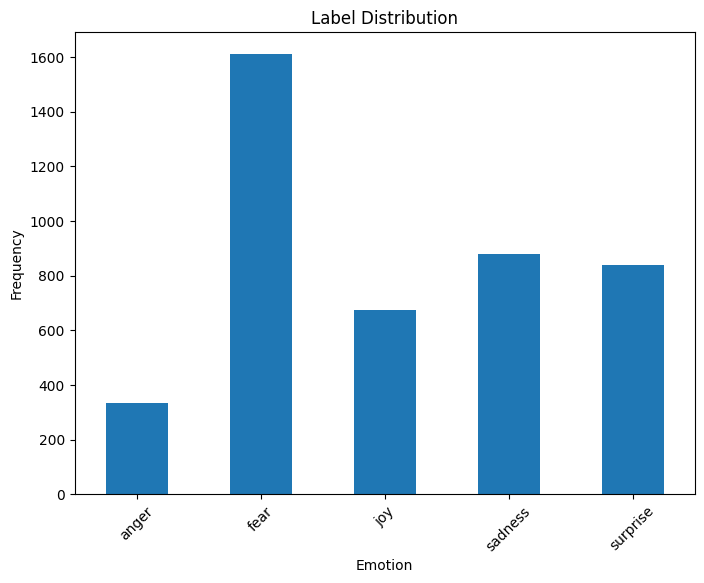


Conflicting Labels Found:
                            id  \
58    eng_train_track_a_00059   
526   eng_train_track_a_00527   
558   eng_train_track_a_00559   
1273  eng_train_track_a_01274   
1309  eng_train_track_a_01310   
2074  eng_train_track_a_02075   
2173  eng_train_track_a_02174   
2294  eng_train_track_a_02295   

                                                   text  anger  fear  joy  \
58    Ah, to close my eyes and let time fly by, Beca...      0     1    0   
526                                   I rolled my eyes.      1     0    0   
558                                      My heart sank.      0     0    0   
1273                                   I shook my head.      0     0    0   
1309  Ah, to close my eyes and let time fly by, Beca...      0     1    0   
2074                                     My heart sank.      0     0    0   
2173                                  I rolled my eyes.      1     0    0   
2294                                   I shook my head.   

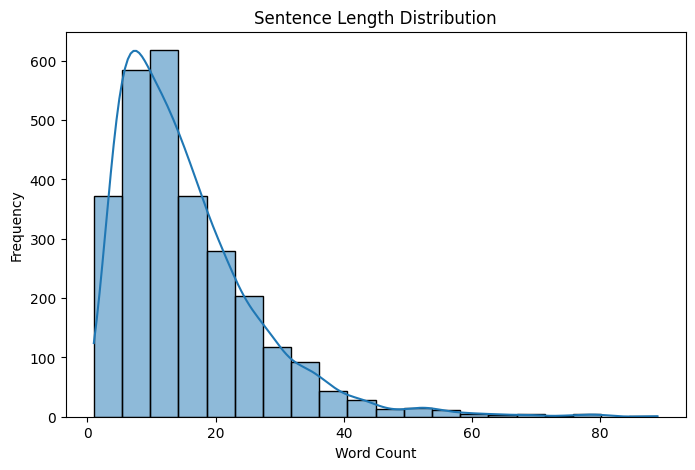


Number of Ambiguous Samples (multiple labels): 1388


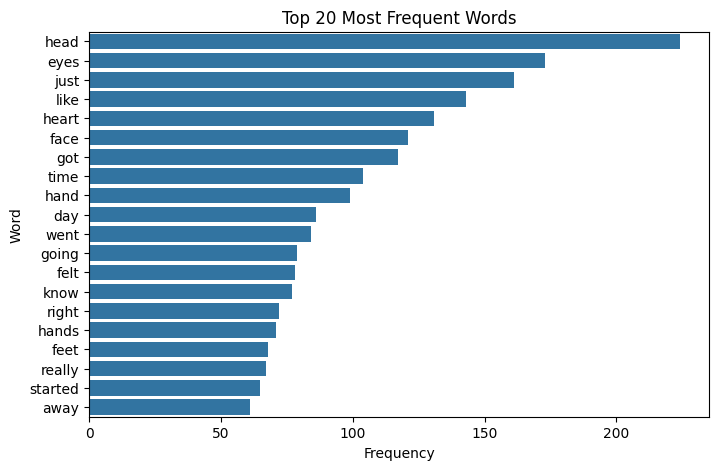

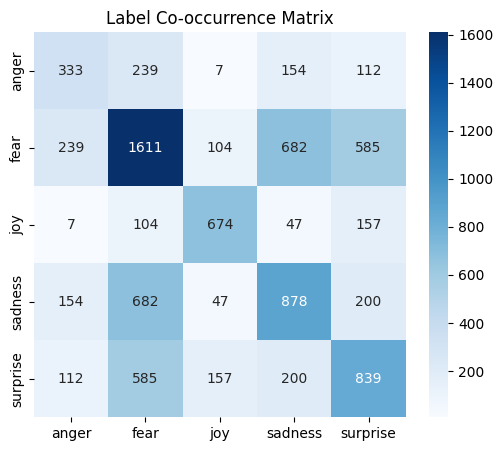

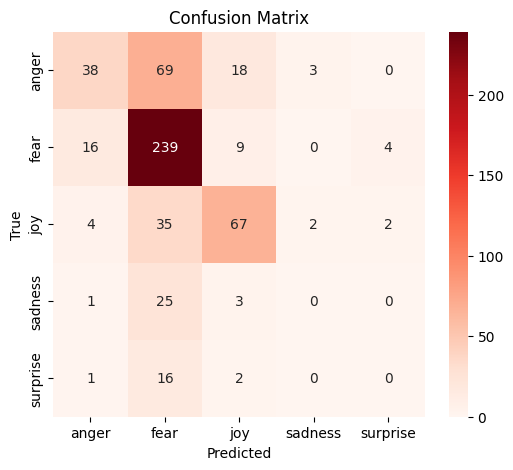

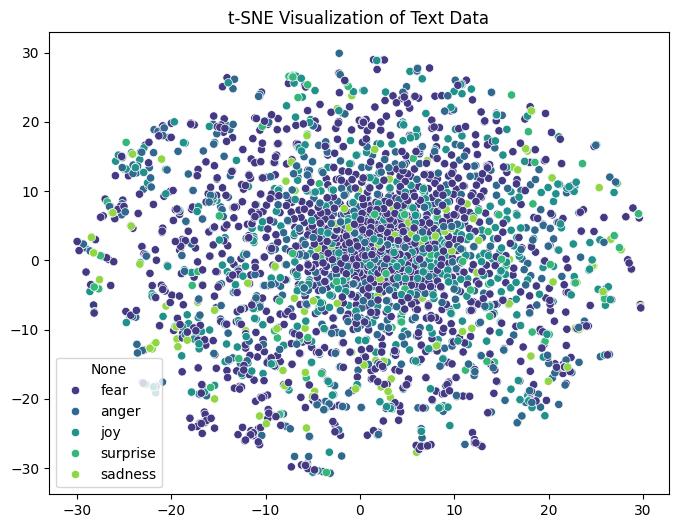

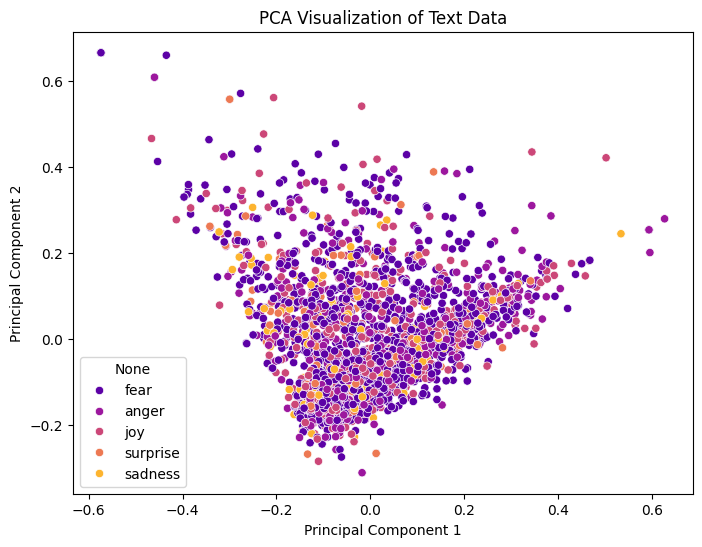

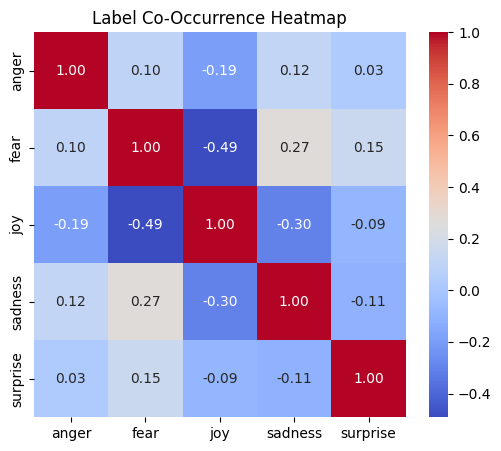

In [19]:
#Data Analysis


import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
# Per-Class Metrics Visualization
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

report_dict = classification_report(val_labels_np, ensemble_pred_labels_np, target_names=["anger", "fear", "joy", "sadness", "surprise"], output_dict=True)

# Plot precision, recall, and F1 for each class
classes = list(report_dict.keys())[:-3]  # Ignore overall metrics
metrics = ['precision', 'recall', 'f1-score']

for metric in metrics:
    values = [report_dict[cls][metric] for cls in classes]
    plt.bar(classes, values, label=metric)

plt.title("Per-Class Metrics")
plt.xlabel("Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.show()

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing Values:\n", missing_values)

# Check for duplicate text entries
duplicate_texts = data['text'].duplicated().sum()
print(f"\nNumber of Duplicate Texts: {duplicate_texts}")

# Class imbalance check
label_counts = data[["anger", "fear", "joy", "sadness", "surprise"]].sum()
print("\nLabel Distribution:\n", label_counts)

plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Label Distribution")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.show()

# Label Distribution Visualization
label_counts.plot(kind='bar', figsize=(8, 6))
plt.title("Label Distribution")
plt.xlabel("Emotion")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# Find conflicting labels (same text with different labels)
duplicate_texts_df = data[data.duplicated(subset=['text'], keep=False)]
if not duplicate_texts_df.empty:
    print("\nConflicting Labels Found:\n", duplicate_texts_df)

# Sentence length distribution
data['text_length'] = data['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 5))
sns.histplot(data['text_length'], bins=20, kde=True)
plt.title("Sentence Length Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# Find highly overlapping labels (ambiguity)
data['total_labels'] = data[["anger", "fear", "joy", "sadness", "surprise"]].sum(axis=1)
ambiguous_samples = data[data['total_labels'] > 1]
print(f"\nNumber of Ambiguous Samples (multiple labels): {len(ambiguous_samples)}")

# Word frequency analysis
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
word_counts = vectorizer.fit_transform(data['text'])
word_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts.toarray().sum(axis=0)))

# Top 20 words
top_words = Counter(word_freq).most_common(20)
top_words_df = pd.DataFrame(top_words, columns=["Word", "Frequency"])

plt.figure(figsize=(8, 5))
sns.barplot(x="Frequency", y="Word", data=top_words_df)
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

# Check label co-occurrence
import seaborn as sns

co_occurrence = data[["anger", "fear", "joy", "sadness", "surprise"]].T.dot(data[["anger", "fear", "joy", "sadness", "surprise"]])
plt.figure(figsize=(6,5))
sns.heatmap(co_occurrence, annot=True, cmap="Blues", fmt="d")
plt.title("Label Co-occurrence Matrix")
plt.show()

# Confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(val_labels_np.argmax(axis=1), ensemble_pred_labels_np.argmax(axis=1))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["anger", "fear", "joy", "sadness", "surprise"], yticklabels=["anger", "fear", "joy", "sadness", "surprise"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


#t-sne

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Convert text into embeddings (use TF-IDF or pre-trained BERT embeddings)
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=300)
X = vectorizer.fit_transform(data['text']).toarray()

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X)

# Plot with labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=data[['anger', 'fear', 'joy', 'sadness', 'surprise']].idxmax(axis=1), palette="viridis")
plt.title("t-SNE Visualization of Text Data")
plt.show()



#pca

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=data[['anger', 'fear', 'joy', 'sadness', 'surprise']].idxmax(axis=1), palette="plasma")
plt.title("PCA Visualization of Text Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

#heatmap

plt.figure(figsize=(6,5))
sns.heatmap(data[["anger", "fear", "joy", "sadness", "surprise"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Label Co-Occurrence Heatmap")
plt.show()



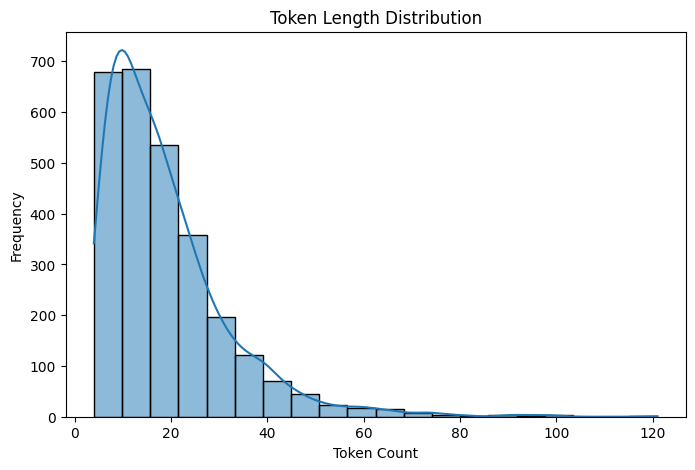

In [20]:
import matplotlib.pyplot as plt
from transformers import BertTokenizer
import pandas as pd
import seaborn as sns

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Assume `data` is a DataFrame containing your dataset
# Add a new column for the token length
data['token_length'] = data['text'].apply(lambda x: len(tokenizer.tokenize(x)))

# Plot the token length distribution
plt.figure(figsize=(8, 5))
sns.histplot(data['token_length'], bins=20, kde=True)
plt.title("Token Length Distribution")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.show()

In [21]:
## ** Strategies for Improvement in data**

In [22]:


# balanced_data_path = '/home/h5/hama461f/Project/balanced_data.csv'
# balanced_data = pd.read_csv(balanced_data_path)

# balanced_data_paraphrase_path = '/home/h5/hama461f/Project/balanced_data_paraphrase_fixed.csv'
# balanced_data_paraphrase = pd.read_csv(balanced_data_paraphrase_path)


In [20]:
#Backtranslated only   3x fear, all else except fear 2x, fear 0x

import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from sklearn.metrics import f1_score, accuracy_score

# Load Data
bt_data_path = '/home/h5/hama461f/Project/backtranslated.csv'
bt_data = pd.read_csv(bt_data_path)
bt_data=bt_data[~(bt_data.iloc[:, 2:] == 0).all(axis=1)] 
# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize Tokenizer & Model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bt_model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=5,
    problem_type="multi_label_classification"
).to(device)


bt_labels = bt_data[['anger', 'fear', 'joy', 'sadness', 'surprise']].values



# Split Data
bt_train_texts, bt_val_texts, bt_train_labels, bt_val_labels = train_test_split(
    bt_data['text'].tolist(), bt_labels.tolist(), test_size=0.2, random_state=401
)


bt_train_dataset = EmotionDataset(bt_train_texts, bt_train_labels, tokenizer)
bt_val_dataset = EmotionDataset(bt_val_texts,bt_val_labels, tokenizer)



def compute_metrics(eval_pred):
    logits, labels = eval_pred  # Unpack logits and labels

    # Convert logits to probabilities using Sigmoid (for multilabel classification)
    probs = torch.sigmoid(torch.tensor(logits)).numpy()

    # Convert probabilities to binary predictions (1 if prob > 0.5, else 0)
    pred_labels = (probs > 0.5).astype(int)

    # Compute F1-score and accuracy for multilabel classification
    f1 = f1_score(labels, pred_labels, average="micro")  # "micro" is best for multilabel tasks
    accuracy = accuracy_score(labels, pred_labels)

    return {"eval_f1": f1, "eval_accuracy": accuracy}


# Training Arguments
training_args = TrainingArguments(
    output_dir='/data/horse/ws/hama461f-BSLLM/final/backtranslatedonly_bert_results',
    num_train_epochs=15,
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    warmup_steps=500,  
    learning_rate=2e-5, 
    weight_decay=0.1,
    logging_dir='/data/horse/ws/hama461f-BSLLM/final/logs',
    load_best_model_at_end=True,
    fp16=True,
    metric_for_best_model="eval_f1",  
    greater_is_better=True
)


# Initialize Trainer
bt_trainer = Trainer(
    model=bt_model,
    args=training_args,
    train_dataset=bt_train_dataset,
    eval_dataset=bt_val_dataset,
    compute_metrics=compute_metrics
)

# Train Model
bt_trainer.train()

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,0.469090,0.726401,0.336000
2,0.527700,0.285555,0.853290,0.579200
3,0.527700,0.191234,0.913728,0.732000
4,0.208300,0.169134,0.927063,0.779200
5,0.075100,0.153850,0.937563,0.818400
6,0.075100,0.147591,0.945252,0.840800
7,0.026200,0.142407,0.945659,0.840000
8,0.011900,0.148341,0.946947,0.848800
9,0.011900,0.155787,0.945919,0.848000
10,0.007000,0.153315,0.946843,0.849600


TrainOutput(global_step=4695, training_loss=0.09263384589752831, metrics={'train_runtime': 281.489, 'train_samples_per_second': 266.387, 'train_steps_per_second': 16.679, 'total_flos': 4932478478165760.0, 'train_loss': 0.09263384589752831, 'epoch': 15.0})

In [21]:
from sklearn.metrics import f1_score, accuracy_score, classification_report,precision_recall_curve

bt_trainer.model.save_pretrained("/data/horse/ws/hama461f-BSLLM/final/backtranslatedonly_bert_results/best_model")

# Run Evaluation
bt_predictions = bt_trainer.predict(bt_val_dataset)

# Optimize Threshold
probs = torch.sigmoid(torch.from_numpy(bt_predictions.predictions)).numpy()
precision, recall, thresholds = precision_recall_curve(np.array(bt_val_labels).ravel(), probs.ravel())
best_threshold = thresholds[np.argmax(precision * recall)]

# Apply Best Threshold
bt_pred_labels = (probs > best_threshold).astype(int)

# Convert Predictions to NumPy
bt_pred_labels_np =bt_pred_labels.astype(int)
bt_val_labels_np = np.array(bt_val_labels)

# Compute F1 Score
f1 = f1_score(bt_val_labels_np, bt_pred_labels_np, average="micro")
print(f"Backtranslated only F1 Score: {f1:.4f}")

# Print Per-Class Performance
print(classification_report(bt_val_labels_np, bt_pred_labels_np, target_names=['anger', 'fear', 'joy', 'sadness', 'surprise']))


Backtranslated only F1 Score: 0.9507
              precision    recall  f1-score   support

       anger       0.95      0.99      0.97       358
        fear       0.94      0.98      0.96       748
         joy       0.94      0.95      0.95       368
     sadness       0.93      0.96      0.94       507
    surprise       0.93      0.94      0.94       500

   micro avg       0.94      0.96      0.95      2481
   macro avg       0.94      0.96      0.95      2481
weighted avg       0.94      0.96      0.95      2481
 samples avg       0.94      0.96      0.94      2481



/home/h5/hama461f/my_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/home/h5/hama461f/my_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


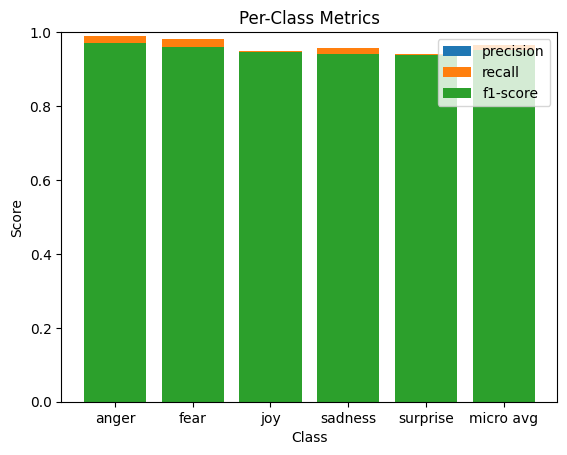

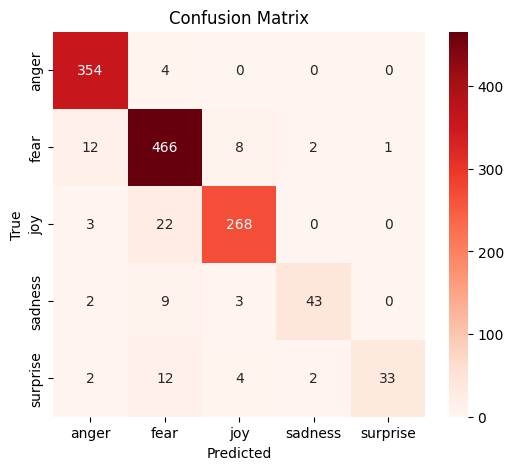

In [28]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
# Per-Class Metrics Visualization
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

report_dict = classification_report(bt_val_labels_np, bt_pred_labels_np, target_names=["anger", "fear", "joy", "sadness", "surprise"], output_dict=True)

# Plot precision, recall, and F1 for each class
classes = list(report_dict.keys())[:-3]  # Ignore overall metrics
metrics = ['precision', 'recall', 'f1-score']

for metric in metrics:
    values = [report_dict[cls][metric] for cls in classes]
    plt.bar(classes, values, label=metric)

plt.title("Per-Class Metrics")
plt.xlabel("Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.show()




from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(bt_val_labels_np.argmax(axis=1), bt_pred_labels_np.argmax(axis=1))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["anger", "fear", "joy", "sadness", "surprise"], yticklabels=["anger", "fear", "joy", "sadness", "surprise"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

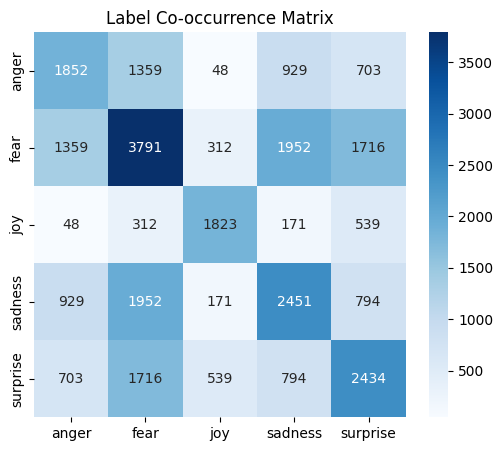

In [29]:
import seaborn as sns

co_occurrence = bt_data[["anger", "fear", "joy", "sadness", "surprise"]].T.dot(bt_data[["anger", "fear", "joy", "sadness", "surprise"]])
plt.figure(figsize=(6,5))
sns.heatmap(co_occurrence, annot=True, cmap="Blues", fmt="d")
plt.title("Label Co-occurrence Matrix")
plt.show()

In [22]:
#Balanced + Paraphrased 3222

import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from sklearn.metrics import f1_score, accuracy_score

# Load Data
btp3_data_path = '/home/h5/hama461f/Project/backtrans_paraph_3222.csv'
btp3_data = pd.read_csv(btp3_data_path)
btp3_data=btp3_data[~(btp3_data.iloc[:, 2:] == 0).all(axis=1)] 
# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize Tokenizer & Model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
btp3_model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=5,
    problem_type="multi_label_classification"
).to(device)


btp3_labels = btp3_data[['anger', 'fear', 'joy', 'sadness', 'surprise']].values



# Split Data
btp3_train_texts, btp3_val_texts,btp3_train_labels, btp3_val_labels = train_test_split(
    btp3_data['text'].tolist(),btp3_labels.tolist(), test_size=0.2, random_state=401
)

# Create Emotion Dataset Class (Ensure it's defined elsewhere)
btp3_train_dataset = EmotionDataset(btp3_train_texts, btp3_train_labels, tokenizer)
btp3_val_dataset = EmotionDataset(btp3_val_texts, btp3_val_labels, tokenizer)



def compute_metrics(eval_pred):
    logits, labels = eval_pred  # Unpack logits and labels

    # Convert logits to probabilities using Sigmoid (for multilabel classification)
    probs = torch.sigmoid(torch.tensor(logits)).numpy()

    # Convert probabilities to binary predictions (1 if prob > 0.5, else 0)
    pred_labels = (probs > 0.5).astype(int)

    # Compute F1-score and accuracy for multilabel classification
    f1 = f1_score(labels, pred_labels, average="micro")  # "micro" is best for multilabel tasks
    accuracy = accuracy_score(labels, pred_labels)

    return {"eval_f1": f1, "eval_accuracy": accuracy}


# Training Arguments
training_args = TrainingArguments(
    output_dir='/data/horse/ws/hama461f-BSLLM/final/bt_p_3222_bert_results',
    num_train_epochs=15,
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    warmup_steps=500,  
    learning_rate=2e-5, 
    weight_decay=0.1,
    logging_dir='/data/horse/ws/hama461f-BSLLM/final/logs',
    load_best_model_at_end=True,
    fp16=True,
    metric_for_best_model="eval_f1",  
    greater_is_better=True
)


# Initialize Trainer
btp3_trainer = Trainer(
    model=btp3_model,
    args=training_args,
    train_dataset=btp3_train_dataset,
    eval_dataset=btp3_val_dataset,
    compute_metrics=compute_metrics
)

# Train Model
btp3_trainer.train()

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,0.544937,0.620617,0.249553
2,0.569800,0.397930,0.780139,0.423971
3,0.569800,0.352253,0.804209,0.463327
4,0.298900,0.296365,0.852270,0.593918
5,0.298900,0.280649,0.862262,0.613596
6,0.137100,0.291337,0.873636,0.645796
7,0.137100,0.282197,0.875376,0.654741
8,0.060000,0.286882,0.883129,0.681574
9,0.030500,0.298343,0.883785,0.681574
10,0.030500,0.310442,0.887523,0.689624


TrainOutput(global_step=4200, training_loss=0.13511826847280775, metrics={'train_runtime': 240.8612, 'train_samples_per_second': 278.252, 'train_steps_per_second': 17.437, 'total_flos': 4408544476984320.0, 'train_loss': 0.13511826847280775, 'epoch': 15.0})

In [23]:
from sklearn.metrics import f1_score, accuracy_score, classification_report,precision_recall_curve

btp3_trainer.model.save_pretrained("/data/horse/ws/hama461f-BSLLM/final/bt_p_3222_bert_results/best_model")

# Run Evaluation
btp3_predictions = btp3_trainer.predict(btp3_val_dataset)

# Optimize Threshold
probs = torch.sigmoid(torch.from_numpy(btp3_predictions.predictions)).numpy()
precision, recall, thresholds = precision_recall_curve(np.array(btp3_val_labels).ravel(), probs.ravel())
best_threshold = thresholds[np.argmax(precision * recall)]

# Apply Best Threshold
btp3_pred_labels = (probs > best_threshold).astype(int)

# Convert Predictions to NumPy
btp3_pred_labels_np = btp3_pred_labels.astype(int)
btp3_val_labels_np = np.array(btp3_val_labels)

# Compute F1 Score
f1 = f1_score(btp3_val_labels_np, btp3_pred_labels_np, average="micro")
print(f"Backtranslated and Paraphrased (3222) F1 Score: {f1:.4f}")

# Print Per-Class Performance
print(classification_report(btp3_val_labels_np, btp3_pred_labels_np, target_names=['anger', 'fear', 'joy', 'sadness', 'surprise']))


Backtranslated and Paraphrased (3222) F1 Score: 0.8918
              precision    recall  f1-score   support

       anger       0.87      0.85      0.86       245
        fear       0.91      0.94      0.92       697
         joy       0.93      0.83      0.87       313
     sadness       0.87      0.89      0.88       487
    surprise       0.89      0.89      0.89       436

   micro avg       0.89      0.89      0.89      2178
   macro avg       0.89      0.88      0.88      2178
weighted avg       0.89      0.89      0.89      2178
 samples avg       0.88      0.88      0.87      2178



/home/h5/hama461f/my_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
#Balanced + Paraphrased 5222

import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from sklearn.metrics import f1_score, accuracy_score

# Load Data
btp5_data_path = '/home/h5/hama461f/Project/backtrans_paraph_5222.csv'
btp5_data = pd.read_csv(btp5_data_path)
btp5_data=btp5_data[~(btp5_data.iloc[:, 2:] == 0).all(axis=1)] 
# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize Tokenizer & Model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
btp5_model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=5,
    problem_type="multi_label_classification"
).to(device)


btp5_labels = btp5_data[['anger', 'fear', 'joy', 'sadness', 'surprise']].values



# Split Data
btp5_train_texts, btp5_val_texts, btp5_train_labels, btp5_val_labels = train_test_split(
    btp5_data['text'].tolist(), btp5_labels.tolist(), test_size=0.2, random_state=401
)

# Create Emotion Dataset Class (Ensure it's defined elsewhere)
btp5_train_dataset = EmotionDataset(btp5_train_texts, btp5_train_labels, tokenizer)
btp5_val_dataset = EmotionDataset(btp5_val_texts, btp5_val_labels, tokenizer)



def compute_metrics(eval_pred):
    logits, labels = eval_pred  # Unpack logits and labels

    # Convert logits to probabilities using Sigmoid (for multilabel classification)
    probs = torch.sigmoid(torch.tensor(logits)).numpy()

    # Convert probabilities to binary predictions (1 if prob > 0.5, else 0)
    pred_labels = (probs > 0.5).astype(int)

    # Compute F1-score and accuracy for multilabel classification
    f1 = f1_score(labels, pred_labels, average="micro")  # "micro" is best for multilabel tasks
    accuracy = accuracy_score(labels, pred_labels)

    return {"eval_f1": f1, "eval_accuracy": accuracy}


# Training Arguments
training_args = TrainingArguments(
    output_dir='/data/horse/ws/hama461f-BSLLM/final/bt_p_5222_bert_results',
    num_train_epochs=15,
    per_device_train_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    warmup_steps=500,  
    learning_rate=2e-5, 
    weight_decay=0.1,
    logging_dir='/data/horse/ws/hama461f-BSLLM/final/logs',
    load_best_model_at_end=True,
    fp16=True,
    metric_for_best_model="eval_f1",  
    greater_is_better=True
)


# Initialize Trainer
btp5_trainer = Trainer(
    model=btp5_model,
    args=training_args,
    train_dataset=btp5_train_dataset,
    eval_dataset=btp5_val_dataset,
    compute_metrics=compute_metrics
)

# Train Model
btp5_trainer.train()

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,0.532699,0.645567,0.250200
2,0.572000,0.373585,0.802814,0.447642
3,0.572000,0.290102,0.856405,0.584333
4,0.292500,0.272590,0.873413,0.634692
5,0.128500,0.251588,0.889464,0.671463
6,0.128500,0.250273,0.895381,0.684253
7,0.057600,0.242614,0.901567,0.712230
8,0.028000,0.244724,0.908328,0.728217
9,0.028000,0.248742,0.910591,0.731415
10,0.014300,0.243290,0.917195,0.752998


TrainOutput(global_step=4695, training_loss=0.11871215568436855, metrics={'train_runtime': 261.6159, 'train_samples_per_second': 286.737, 'train_steps_per_second': 17.946, 'total_flos': 4934451864234240.0, 'train_loss': 0.11871215568436855, 'epoch': 15.0})

In [26]:

from sklearn.metrics import f1_score, accuracy_score, classification_report,precision_recall_curve

btp5_trainer.model.save_pretrained("/data/horse/ws/hama461f-BSLLM/final/bt_p_5222_bert_results/best_model")

# Run Evaluation
btp5_predictions = btp5_trainer.predict(btp5_val_dataset)

# Optimize Threshold
probs = torch.sigmoid(torch.from_numpy(btp5_predictions.predictions)).numpy()
precision, recall, thresholds = precision_recall_curve(np.array(btp5_val_labels).ravel(), probs.ravel())
best_threshold = thresholds[np.argmax(precision * recall)]

# Apply Best Threshold
btp5_pred_labels = (probs > best_threshold).astype(int)

# Convert Predictions to NumPy
btp5_pred_labels_np = btp5_pred_labels.astype(int)
btp5_val_labels_np = np.array(btp5_val_labels)

# Compute F1 Score
f1 = f1_score(btp5_val_labels_np, btp5_pred_labels_np, average="micro")
print(f"Backtranslated and Paraphrased (5222) F1 Score: {f1:.4f}")

# Print Per-Class Performance
print(classification_report(btp5_val_labels_np, btp5_pred_labels_np, target_names=['anger', 'fear', 'joy', 'sadness', 'surprise']))


Backtranslated and Paraphrased (5222) F1 Score: 0.9182
              precision    recall  f1-score   support

       anger       0.89      0.95      0.92       390
        fear       0.93      0.96      0.94       782
         joy       0.92      0.83      0.87       301
     sadness       0.91      0.91      0.91       551
    surprise       0.92      0.91      0.92       496

   micro avg       0.92      0.92      0.92      2520
   macro avg       0.91      0.91      0.91      2520
weighted avg       0.92      0.92      0.92      2520
 samples avg       0.90      0.91      0.90      2520



/home/h5/hama461f/my_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [44]:
import torch
import torch.nn.functional as F
from transformers import BertTokenizer

#  BERT tokenizer
tokenizer_bt = BertTokenizer.from_pretrained("bert-base-uncased")  

#Model is in evaluation mode
bt_model.eval()


label_names = ["anger", "fear", "joy", "sadness", "surprise"]


def predict_emotions_bt(text, threshold=0.5):
    """
    Predicts emotions for a given text using BERT model (model_bt).
    
    Args:
        text (str): Input sentence.
        threshold (float): Probability threshold for classifying an emotion.

    Returns:
        list: Predicted emotions or "No strong emotion detected".
    """
    # Tokenize input text using BERT tokenizer
    inputs = tokenizer_bt(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Move input tensors to the correct device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bt_model.to(device)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get model predictions
    with torch.no_grad():
        outputs = bt_model(**inputs)
    
    # Apply sigmoid activation to get probability scores (for multi-label classification)
    probs = F.sigmoid(outputs.logits).squeeze().tolist()

    # Convert probabilities to binary labels (apply threshold)
    predictions = [label for label, prob in zip(label_names, probs) if prob >= threshold]

    return predictions if predictions else ["No strong emotion detected"]

# Interactive Input Mode
if __name__ == "__main__":
    while True:
        text = input("\nEnter text (or type 'exit' to quit): ").strip()
        if text.lower() == "exit":
            break
        predicted_emotions = predict_emotions_bt(text)
        print(f"Predicted emotions: {predicted_emotions}")



Enter text (or type 'exit' to quit):  what are you doing???


Predicted emotions: ['fear', 'surprise']



Enter text (or type 'exit' to quit):  nice to see you


Predicted emotions: ['joy']



Enter text (or type 'exit' to quit):  wtf?


Predicted emotions: ['anger', 'fear', 'surprise']



Enter text (or type 'exit' to quit):  i cannot


Predicted emotions: ['fear', 'sadness', 'surprise']



Enter text (or type 'exit' to quit):  im so sorry


Predicted emotions: ['fear']



Enter text (or type 'exit' to quit):  so so sorry


Predicted emotions: ['sadness']



Enter text (or type 'exit' to quit):  im scared to say this


Predicted emotions: ['fear']



Enter text (or type 'exit' to quit):  im scared to say this, but i love you


Predicted emotions: ['fear', 'joy']



Enter text (or type 'exit' to quit):  crazy experience


Predicted emotions: ['fear', 'surprise']



Enter text (or type 'exit' to quit):  love it


Predicted emotions: ['joy']



Enter text (or type 'exit' to quit):  did not love it


Predicted emotions: ['anger', 'sadness']



Enter text (or type 'exit' to quit):  no


Predicted emotions: ['fear', 'surprise']



Enter text (or type 'exit' to quit):  shit!!


Predicted emotions: ['anger', 'surprise']



Enter text (or type 'exit' to quit):  hahaa


Predicted emotions: ['joy', 'surprise']



Enter text (or type 'exit' to quit):  i love you


Predicted emotions: ['joy']



Enter text (or type 'exit' to quit):  do you love me


Predicted emotions: ['joy']



Enter text (or type 'exit' to quit):  do you love me?


Predicted emotions: ['surprise']



Enter text (or type 'exit' to quit):  do you love me?


Predicted emotions: ['surprise']



Enter text (or type 'exit' to quit):  do you love me


Predicted emotions: ['joy']



Enter text (or type 'exit' to quit):  exit
